VGG块

In [14]:
import torch
from torch import nn
from d2l import torch as d2l

def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    # 卷积层叠加，第一个卷积层调整好输入、输出通道，后续卷积层输出通道相同
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))  # 保持高度、宽度不变  -3 + 2 + 1
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))  # (  -2 + 2)/2  , 每个块后的分辨率减半
    return nn.Sequential(*layers)  # 组装VGG块内各神经网络层

VGG网络

In [15]:
# 网络使用8个卷积层和3个全连接层，通常被称为VGG-11
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512)) # (卷积层个数， 输出通道)

In [16]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1  # 初始输入通道数
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels
    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels*7*7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10)
    )

net = vgg(conv_arch)

In [17]:
# 观察每个层输出的形状
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__, 'output shape:\t', X.shape)


Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


训练模型 ———— 由于VGG-11比AlexNet的计算量更大，将输出通道数缩小4倍(足够训练Fashion-MNIST数据集)

In [22]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

loss 0.225, train acc 0.916, test acc 0.871
238.2 examples/sec on xpu:0


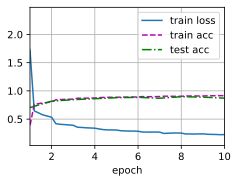

In [10]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

def try_xpu(i=0):
    """如果存在,则返回gpu(i),否则返回cpu()"""
    if torch.xpu.device_count() >= i+1:
        return torch.device(f'xpu:{i}')
    return torch.device('cpu')
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, try_xpu())

练习

在观察每个层输出的形状时，只打印出8个层(Sequential, linear), 这是由于代码只输出了每个Sequential的最后输出shape，没有显示子层

In [12]:
net

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4): Seque

尝试将Fashion-MNIST数据集图像的高度和宽度从224改为96

In [38]:
def my_vgg(conv_arch):
    conv_blks = []
    in_channels = 1  # 初始输入通道数
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels
    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels*3*3, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10)
    )

In [39]:
# 网络使用8个卷积层和3个全连接层，通常被称为VGG-11
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512)) # (卷积层个数， 输出通道)
# 放缩4倍
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = my_vgg(small_conv_arch)

In [40]:
X = torch.randn(size=(1, 1, 96, 96))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__, 'output shape:\t', X.shape)


Sequential output shape:	 torch.Size([1, 16, 48, 48])
Sequential output shape:	 torch.Size([1, 32, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 12, 12])
Sequential output shape:	 torch.Size([1, 128, 6, 6])
Sequential output shape:	 torch.Size([1, 128, 3, 3])
Flatten output shape:	 torch.Size([1, 1152])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


loss 0.239, train acc 0.911, test acc 0.900
1059.8 examples/sec on xpu:0


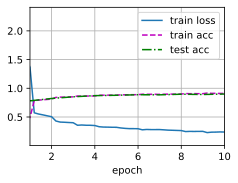

In [41]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, try_xpu())

参考论文，构建VGG-16
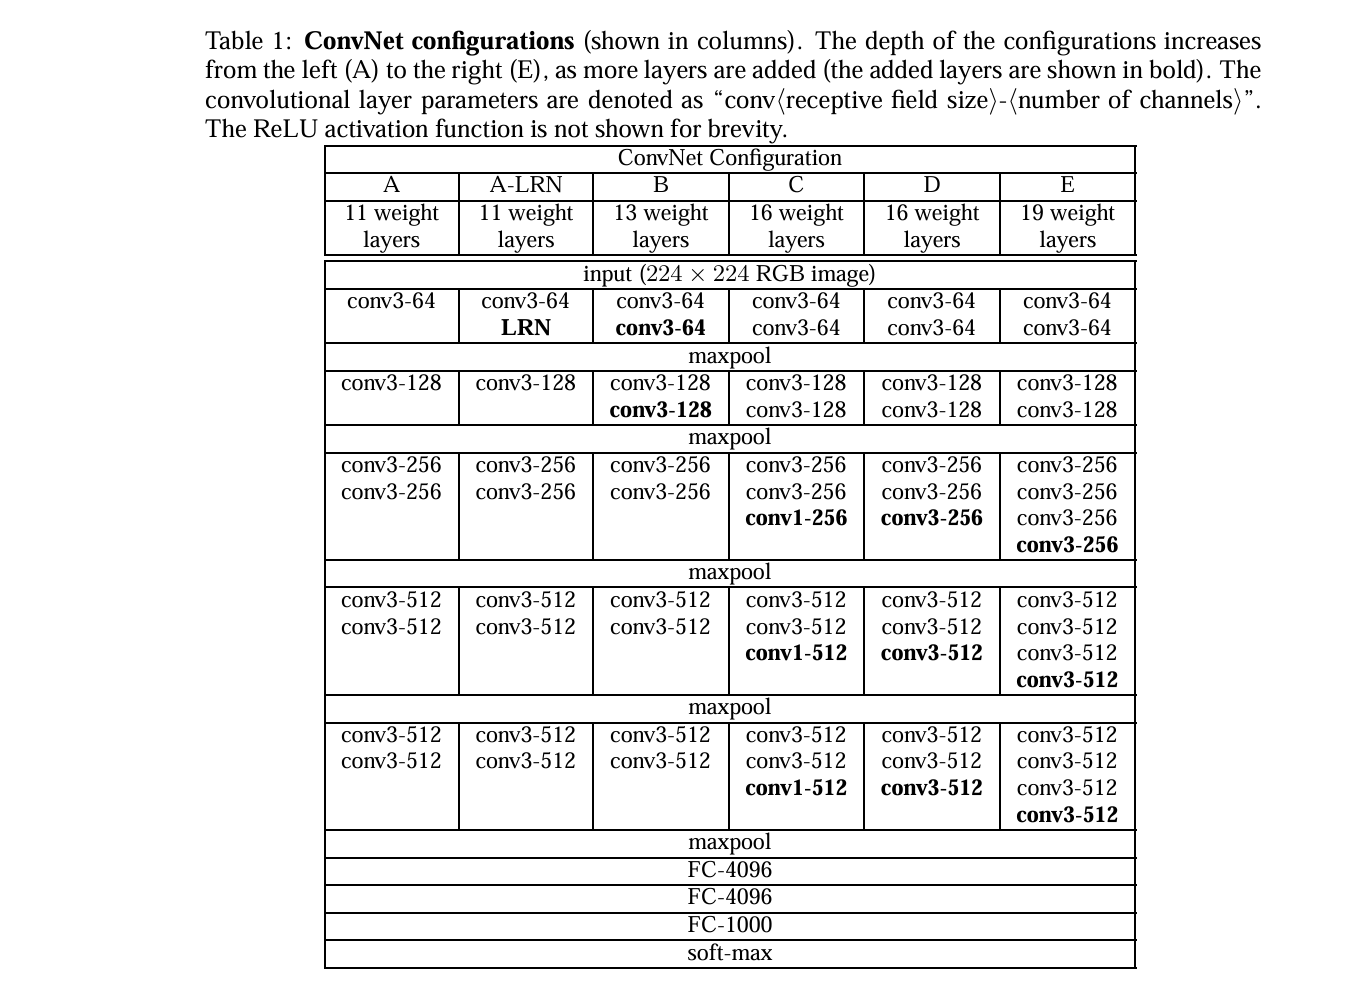

In [44]:
def my_vgg16(conv_arch):
    conv_blks = []
    in_channels = 1  # 初始输入通道数
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels
    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels*7*7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10)
    )

# VGG-16
conv_arch = ((2, 64), (2, 128), (3, 256), (3, 512), (3, 512)) # (卷积层个数， 输出通道)
# 放缩4倍
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = my_vgg16(small_conv_arch)

In [45]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__, 'output shape:\t', X.shape)


Sequential output shape:	 torch.Size([1, 16, 112, 112])
Sequential output shape:	 torch.Size([1, 32, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 28, 28])
Sequential output shape:	 torch.Size([1, 128, 14, 14])
Sequential output shape:	 torch.Size([1, 128, 7, 7])
Flatten output shape:	 torch.Size([1, 6272])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


loss 0.181, train acc 0.934, test acc 0.920
102.9 examples/sec on xpu:0


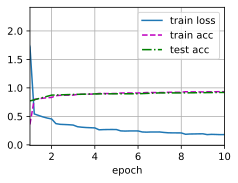

In [46]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, try_xpu())